In [1]:
import numpy as np
import pandas as pd
import os
import argparse

import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

from scipy.stats import pearsonr, linregress, ttest_ind, mannwhitneyu, kendalltau, spearmanr

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder

def autopct_format(values):
    def my_format(pct):
        absolute = round(pct / 100. * sum(values))
        return f"{absolute} ({pct:.1f}%)"
    return my_format

In [2]:
root = "D:\JoanFR_Sano\Glioblastoma_UPENN-GBM_v2-20221024"
fmt = "svg"
stream_th = 0
figs_folder = f"Demographics-GBM"
os.makedirs(os.path.join(root, "Figures/TDMaps_IDH1-WT",figs_folder), exist_ok=True)
daysXmonth = 365/12

<>:1: SyntaxWarning: invalid escape sequence '\J'
<>:1: SyntaxWarning: invalid escape sequence '\J'
C:\Users\user\AppData\Local\Temp\ipykernel_13260\1525842019.py:1: SyntaxWarning: invalid escape sequence '\J'
  root = "D:\JoanFR_Sano\Glioblastoma_UPENN-GBM_v2-20221024"


# We inspect the full clinical sample, without filters

In [3]:
figs = os.path.join(root, "Figures")
os.makedirs(figs, exist_ok=True)
clinical_raw_full = pd.read_csv(os.path.join(root, "data/UPENN-GBM_clinical_info_v2.1.csv"), sep=',')
clinical_raw_full.head()

,ID,Gender,Age_at_scan_years,Survival_from_surgery_days_UPDATED,Survival_Status,Survival_Censor,IDH1,MGMT,KPS,GTR_over90percent,Time_since_baseline_preop,PsP_TP_score
0,UPENN-GBM-00001_11,F,52.16,960,Deceased,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
1,UPENN-GBM-00002_11,F,61.30,291,Deceased,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
2,UPENN-GBM-00003_11,M,42.82,2838,Deceased,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
3,UPENN-GBM-00004_11,M,33.43,623,Deceased,Not Available,NOS/NEC,Not Available,Not Available,Y,0,NaN
4,UPENN-GBM-00005_11,M,53.33,1143,Deceased,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN


There is an earlier version for the clinical data named v1.0. Even though we will work with the version 2.1, we will load the earlier version to keep track of the changes w.r.t. the publication describing the dataset (Bakas, et al. 2022).

In [4]:
clinical_raw_full_1 = pd.read_csv(os.path.join(root, "data/UPENN-GBM_clinical_info_v1.0.csv"), sep=',')
clinical_raw_full_1.head()

,ID,Gender,Age_at_scan_years,Survival_from_surgery_days,IDH1,MGMT,KPS,GTR_over90percent,Time_since_baseline_preop,PsP_TP_score
0,UPENN-GBM-00001_11,F,52.16,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
1,UPENN-GBM-00002_11,F,61.30,291,Wildtype,Not Available,Not Available,Y,0,NaN
2,UPENN-GBM-00003_11,M,42.82,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
3,UPENN-GBM-00004_11,M,33.43,Not Available,NOS/NEC,Not Available,Not Available,Y,0,NaN
4,UPENN-GBM-00005_11,M,53.33,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN


There is also a csv file that describes the data available for each subject. However, the new version does not adequately correspond to the UPDATED version of the of the dataset. In fact, the available survival data for the new version of the data is much higher than the 452 reported in Bakas, et al. 2022.

In [5]:
available_data = pd.read_csv(os.path.join(root, "data/UPENN-GBM_data_availability.csv"), sep=',')
available_data.groupby(["Overall Survival"])["MGMT"].count()

Overall Survival
available        452
not available    219
Name: MGMT, dtype: int64

In [6]:
print("Survival data for version 1.0: ", len(clinical_raw_full_1.loc[clinical_raw_full_1["Survival_from_surgery_days"]!="Not Available"]))
print("Survival data for version 2.0: ", len(clinical_raw_full_1.loc[clinical_raw_full["Survival_from_surgery_days_UPDATED"]!="Not Available"]))

Survival data for version 1.0:  452
Survival data for version 2.0:  644


The other source of conflict that we identified w.r.t. Bakas, et al. 2022 is the MGMT promoter identification. However, there is no way to reconcile the data present in both versions with the numbers reported in the publication. 
It is possible that a mistake was made and we should notify the authors.

In [7]:
available_data1 = pd.read_csv(os.path.join(root, "data/UPENN-GBM_data_availability_v1.0.csv"), sep=',')
available_data1.loc[available_data1["Associated Baseline Scan"]=="-"].groupby(["MGMT"]).count()

,ID,Structural imaging,DTI imaging,DSC imaging,Automatic Tumor Segmentation,Corrected Tumor Segmentation,Gender,Age,Overall Survival,IDH1,KPS,Extent of Resection,Associated Baseline Scan,Associated Recurrence Scan,PsP_TP score,CaPTk Radiomic Features
MGMT,,,,,,,,,,,,,,,,
available,262,262,262,262,262,262,262,262,262,262,262,262,262,262,262,262
not available,349,349,349,349,349,349,349,349,349,349,349,349,349,349,349,349


In [8]:
available_data.loc[available_data["Associated Baseline Scan"]=="-"].groupby(["MGMT"]).count()

,ID,Structural imaging,DTI imaging,DSC imaging,Automatic Tumor Segmentation,Corrected Tumor Segmentation,Gender,Age,Overall Survival,IDH1,KPS,Extent of Resection,Associated Baseline Scan,Associated Recurrence Scan,PsP_TP score,CaPTk Radiomic Features
MGMT,,,,,,,,,,,,,,,,
available,262,262,262,262,262,262,262,262,262,262,262,262,262,262,262,262
not available,349,349,349,349,349,349,349,349,349,349,349,349,349,349,349,349


In [9]:
clinical_raw_full_1.loc[clinical_raw_full_1["Time_since_baseline_preop"]=="0"].groupby(["MGMT"]).count()

,ID,Gender,Age_at_scan_years,Survival_from_surgery_days,IDH1,KPS,GTR_over90percent,Time_since_baseline_preop,PsP_TP_score
MGMT,,,,,,,,,
Indeterminate,27,27,27,27,27,27,27,27,0
Methylated,111,111,111,111,111,111,111,111,0
Not Available,322,322,322,322,322,322,322,322,0
Unmethylated,151,151,151,151,151,151,151,151,0


In [10]:
clinical_raw_full.loc[clinical_raw_full["Time_since_baseline_preop"]=="0"].groupby(["MGMT"]).count()

,ID,Gender,Age_at_scan_years,Survival_from_surgery_days_UPDATED,Survival_Status,Survival_Censor,IDH1,KPS,GTR_over90percent,Time_since_baseline_preop,PsP_TP_score
MGMT,,,,,,,,,,,
Indeterminate,27,27,27,27,27,27,27,27,27,27,0
Methylated,111,111,111,111,111,111,111,111,111,111,0
Not Available,322,322,322,322,322,322,322,322,322,322,0
Unmethylated,151,151,151,151,151,151,151,151,151,151,0


### We need to understand the meaning of follow-up times and scans in order to know whether they should be discarded or not

In [11]:
# Let's consider an example first
ex_available = available_data.loc[(available_data["ID"]=="UPENN-GBM-00352_11") | (available_data["ID"]=="UPENN-GBM-00352_21")]
ex_clinical = clinical_raw_full.loc[(clinical_raw_full["ID"]=="UPENN-GBM-00352_11") | (clinical_raw_full["ID"]=="UPENN-GBM-00352_21")]
ex_clinical

,ID,Gender,Age_at_scan_years,Survival_from_surgery_days_UPDATED,Survival_Status,Survival_Censor,IDH1,MGMT,KPS,GTR_over90percent,Time_since_baseline_preop,PsP_TP_score
388,UPENN-GBM-00352_11,M,42.61,617,Deceased,Not Available,Wildtype,Unmethylated,90,Y,0,NaN
389,UPENN-GBM-00352_21,M,42.86,519,Deceased,Not Available,Wildtype,Methylated,Not Available,Not Applicable,91,4.0


In this case, patient 00352_11 survived a total of 617 days from the first surgery, and 519 from a second one. That means that between surgeries, a total of 98 days elapsed. The time of the second scan from the first surgery was 91 days, which allows us to estimate a 7-day period between the follow-up scan and the second surgery. Follow-up scans and survival times were not considered in the analyses since they required an additional control for confounding factors.

In [12]:
clinical_raw = clinical_raw_full.copy()
clinical_raw = clinical_raw.loc[clinical_raw["Time_since_baseline_preop"]=="0"]
clinical_raw.head()

,ID,Gender,Age_at_scan_years,Survival_from_surgery_days_UPDATED,Survival_Status,Survival_Censor,IDH1,MGMT,KPS,GTR_over90percent,Time_since_baseline_preop,PsP_TP_score
0,UPENN-GBM-00001_11,F,52.16,960,Deceased,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
1,UPENN-GBM-00002_11,F,61.30,291,Deceased,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
2,UPENN-GBM-00003_11,M,42.82,2838,Deceased,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
3,UPENN-GBM-00004_11,M,33.43,623,Deceased,Not Available,NOS/NEC,Not Available,Not Available,Y,0,NaN
4,UPENN-GBM-00005_11,M,53.33,1143,Deceased,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN


# Sample with WHO 2021 Glioblastomas patients and tract density-based markers

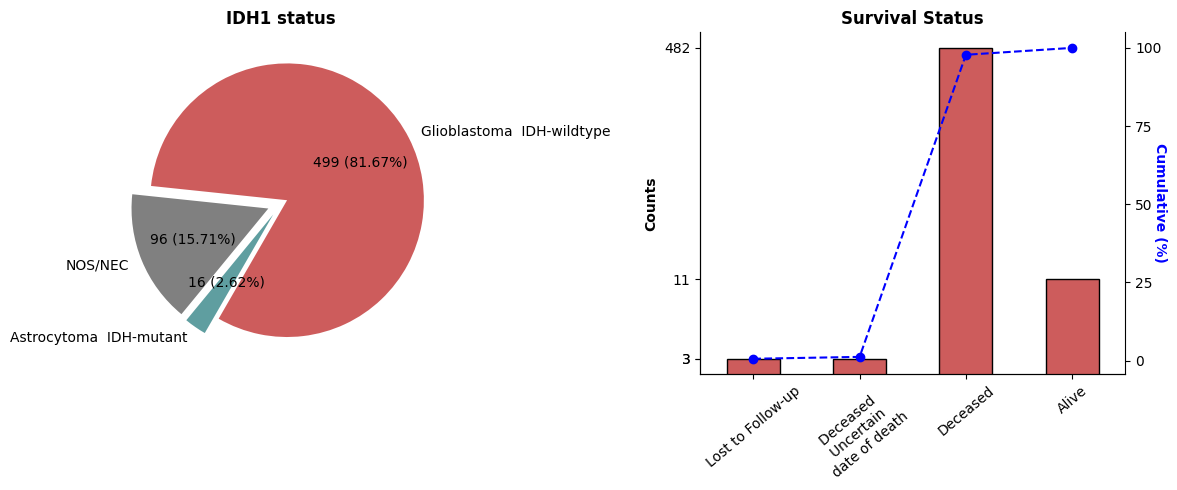

In [13]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

dt = clinical_raw["IDH1"].value_counts()
dt.plot.pie(
    ax=ax[0],
    labels=["Glioblastoma  IDH-wildtype", "NOS/NEC", "Astrocytoma  IDH-mutant"],
    autopct=lambda p: '{:.0f} ({:.2f}%)'.format((p/100)*dt.sum(),p),
    colors=["indianred", "gray", "cadetblue"],
    explode=[0.05, 0.1, 0.1],
    startangle=240
)
ax[0].set_title("IDH1 status", fontweight='bold')
ax[0].set_ylabel("")


dt = clinical_raw.loc[clinical_raw["IDH1"] == "Wildtype"]["Survival_Status"].value_counts()
dt = dt.sort_index(ascending=False)  # Reverse the order of bars
bars = dt.plot.bar(
    ax=ax[1],
    color="indianred",
    edgecolor="black"
)
ax[1].spines[["top", "right"]].set_visible(False)
ax[1].set_title("Survival Status", fontweight="bold")
ax[1].set_xlabel(None)
ax[1].set_ylabel("Counts", fontweight="bold")
ax[1].set_yscale("log")  # Semilogy scale
ax[1].set_yticks(dt.values)
ax[1].set_yticklabels([f"{val}" for val in dt.values])
ax[1].yaxis.set_minor_locator(plt.NullLocator())  # This disables the small y-tick marks
ax[1].set_xticklabels(["Lost to Follow-up","Deceased \nUncertain \ndate of death", "Deceased", "Alive"],rotation=40)

cumulative_percent = (dt.cumsum() / dt.sum()) * 100
ax2 = ax[1].twinx()
ax2.spines[["top"]].set_visible(False)
ax2.plot(
    cumulative_percent.index,
    cumulative_percent,
    color="blue",
    linestyle="--",
    marker="o",
    label="Cumulative (%)"
)
ax2.set_ylabel("Cumulative (%)", fontweight="bold", color="blue", rotation=270)
ax2.set_yticks([0,25,50,75,100])

fig.tight_layout()
fig.savefig(os.path.join(root, f"Figures/TDMaps_IDH1-WT/{figs_folder}/diagnosis_KM.{fmt}"), dpi=300, format=fmt, transparent=True, bbox_inches='tight')
#plt.close()

The 3 patients with "Uncertain date of death" will be further discarded. Let's consider the patients with a confirmed WHO 2021 glioblastoma diagnosis and available (or usable) survival data.

In [14]:
glioblastoma2021_sample = clinical_raw.loc[(clinical_raw["IDH1"]=="Wildtype") & (clinical_raw["Survival_Status"]!="Deceased - uncertain date of death")]

# Change to 1-dead / 0-alive or lost to follow-up
glioblastoma2021_survival = glioblastoma2021_sample.copy()
glioblastoma2021_survival["Survival_Status"] = glioblastoma2021_sample["Survival_Status"].apply(
    lambda x: 1 if x == "Deceased" else 0
)

# Move the censoring time to the "survival in days" column
glioblastoma2021_OS = glioblastoma2021_survival.copy()
glioblastoma2021_OS.loc[
    glioblastoma2021_OS["Survival_Status"] == 0, 
    "Survival_from_surgery_days_UPDATED"
] = glioblastoma2021_OS["Survival_Censor"]

# Drop useless columns
glioblastoma2021_OS = glioblastoma2021_OS.drop(columns=["Survival_Censor", "IDH1","Time_since_baseline_preop","PsP_TP_score"])
glioblastoma2021_OS.to_csv(os.path.join(root, "data/UPENN-GBM_clinical_info_v3.0.csv"), index=None)
glioblastoma2021_OS.groupby(["MGMT"], dropna=False).count()

,ID,Gender,Age_at_scan_years,Survival_from_surgery_days_UPDATED,Survival_Status,KPS,GTR_over90percent
MGMT,,,,,,,
Indeterminate,25,25,25,25,25,25,25
Methylated,103,103,103,103,103,103,103
Not Available,217,217,217,217,217,217,217
Unmethylated,151,151,151,151,151,151,151


In [15]:
astrocytoma2021_sample = clinical_raw.loc[(clinical_raw["IDH1"]=="Mutated") & (clinical_raw["Survival_Status"]!="Deceased - uncertain date of death")]

# Change to 1-dead / 0-alive or lost to follow-up
astrocytoma2021_survival = astrocytoma2021_sample.copy()
astrocytoma2021_survival["Survival_Status"] = astrocytoma2021_sample["Survival_Status"].apply(
    lambda x: 1 if x == "Deceased" else 0
)

# Move the censoring time to the "survival in days" column
astrocytoma2021_OS = astrocytoma2021_survival.copy()
astrocytoma2021_OS.loc[
    astrocytoma2021_OS["Survival_Status"] == 0, 
    "Survival_from_surgery_days_UPDATED"
] = astrocytoma2021_OS["Survival_Censor"]

# Drop useless columns
astrocytoma2021_OS = astrocytoma2021_OS.drop(columns=["Survival_Censor", "IDH1","Time_since_baseline_preop","PsP_TP_score"])
astrocytoma2021_OS.to_csv(os.path.join(root, "data/UPENN-GBM_clinical_info_v4.0_Astrocytoma-only.csv"), index=None)
astrocytoma2021_OS.groupby(["MGMT"], dropna=False).count()

,ID,Gender,Age_at_scan_years,Survival_from_surgery_days_UPDATED,Survival_Status,KPS,GTR_over90percent
MGMT,,,,,,,
Indeterminate,2,2,2,2,2,2,2
Methylated,7,7,7,7,7,7,7
Not Available,7,7,7,7,7,7,7


Do all of these patients have available preop imaging data?

In [16]:
total = 0
for subject in glioblastoma2021_OS.iloc:
    ID = subject["ID"]
    df = available_data.loc[available_data["ID"]==ID]
    df = df[["ID","Structural imaging","Automatic Tumor Segmentation", "Corrected Tumor Segmentation"]]
    OK = True if (df["Automatic Tumor Segmentation"].values[0]=="available") and (df["Structural imaging"].values[0]=="available") else False
    if not OK:
        total += 1
        print(f"{ID} without usable imaging data")
print("Number of glioblastoma patients with imaging data: ", len(glioblastoma2021_OS)-total)
print("Number of glioblastoma patients without imaging data: ", total)

Number of glioblastoma patients with imaging data:  496
Number of glioblastoma patients without imaging data:  0


In [17]:
total = 0
for subject in astrocytoma2021_OS.iloc:
    ID = subject["ID"]
    df = available_data.loc[available_data["ID"]==ID]
    df = df[["ID","Structural imaging","Automatic Tumor Segmentation", "Corrected Tumor Segmentation"]]
    OK = True if (df["Automatic Tumor Segmentation"].values[0]=="available") and (df["Structural imaging"].values[0]=="available") else False
    if not OK:
        total += 1
        print(f"{ID} without usable imaging data")
print("Number of astrocytoma patients with imaging data: ", len(astrocytoma2021_OS)-total)
print("Number of astrocytoma patients without imaging data: ", total)

Number of astrocytoma patients with imaging data:  16
Number of astrocytoma patients without imaging data:  0


Now we can plot the survival of the glioblastoma and astrocytoma groups. Only those with imaging and survival data: 496 GBM and 16 Astrocytoma.

In [18]:
fig, ax = plt.subplots(1,1, figsize=(6,5))
colors = ["indianred", "cadetblue"]
OS_STATS = []
GROUP_STATS = []
nums = np.empty(shape=(2,), dtype=object)
months = range(0,110,10)

# Glioblastoma
diag = glioblastoma2021_OS
nums[0] = []
for t in months:
    nums[0].append((diag["Survival_from_surgery_days_UPDATED"].to_numpy(dtype=np.float64)>=(t*daysXmonth)).sum())

time, survival_prob, conf_int = kaplan_meier_estimator(
            diag["Survival_Status"]==1, diag["Survival_from_surgery_days_UPDATED"], conf_type="log-log"
        )
ax.step(time/daysXmonth, survival_prob, where="post", label=f"Male", color=colors[0])
ax.fill_between(time/daysXmonth, conf_int[0], conf_int[1], alpha=0.15, step="post", color=colors[0])
for t in diag.loc[diag["Survival_Status"]==0, "Survival_from_surgery_days_UPDATED"].values: # Censoring times
    ax.plot(time[time==float(t)]/daysXmonth, survival_prob[time==float(t)], "|", color=colors[0])

OS_STATS.extend([(st, ovs) for st, ovs in zip(diag["Survival_Status"]==1, diag["Survival_from_surgery_days_UPDATED"].values)])
GROUP_STATS.extend([1 for ovs in diag["Survival_from_surgery_days_UPDATED"].values])

# Astrocytoma
diag = astrocytoma2021_OS
nums[1] = []
for t in months:
    nums[1].append((diag["Survival_from_surgery_days_UPDATED"].to_numpy(dtype=np.float64)>=(t*daysXmonth)).sum())

time, survival_prob, conf_int = kaplan_meier_estimator(
            diag["Survival_Status"]==1, diag["Survival_from_surgery_days_UPDATED"], conf_type="log-log"
        )
ax.step(time/daysXmonth, survival_prob, where="post", label=f"Male", color=colors[1])
ax.fill_between(time/daysXmonth, conf_int[0], conf_int[1], alpha=0.15, step="post", color=colors[1])
for t in diag.loc[diag["Survival_Status"]==0, "Survival_from_surgery_days_UPDATED"].values: # Censoring times
    ax.plot(time[time==float(t)]/daysXmonth, survival_prob[time==float(t)], "|", color=colors[1])

OS_STATS.extend([(st, ovs) for st, ovs in zip(diag["Survival_Status"]==1, diag["Survival_from_surgery_days_UPDATED"].values)])
GROUP_STATS.extend([2 for ovs in diag["Survival_from_surgery_days_UPDATED"].values])

OS_STATS = np.array(OS_STATS, dtype=[('event', 'bool'),('time', 'float')])
chisquared, p_val, stats, covariance = compare_survival(OS_STATS, GROUP_STATS, return_stats=True)
ax.text(0.80, 0.95, r"$\chi^2 =$"+f"{round(chisquared,4)}, \np = {round(p_val,4)}", transform=ax.transAxes, 
                    fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.1), color="red" if p_val<=0.05 else "black")        

# Number of patients at risk
for i,t in enumerate(months):
    ax.text(t-2, -0.07, f"{nums[0][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[0]) 
    ax.text(t-2, -0.13, f"{nums[1][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[1]) 
ax.text(-2, -0.01, "No. at risk", transform=ax.transData, fontsize=11, verticalalignment='top', color="black", fontweight='bold') 
ax.hlines(0,-5,months[-1]+5, color="black", linewidth=.5)
ax.set_ylim([-.2,1])
ax.set_xlim([-5,75])
ax.set_xticks(months)
ax.set_xticklabels(months)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1])
ax.spines['left'].set_bounds(0,1)
ax.spines['bottom'].set_bounds(months[0], months[-1])
ax.set_xlabel("Time (months)", fontsize=12)
ax.set_ylabel("Overall survival", fontsize=12)
ax.spines[["top", "right"]].set_visible(False)

fig.tight_layout()
fig.savefig(os.path.join(root, f"Figures/TDMaps_IDH1-WT/{figs_folder}/diagnosis_KM.{fmt}"), dpi=300, format=fmt, transparent=True, bbox_inches='tight')
plt.close(fig)

### Age and sex in the glioblastoma sample

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
glioblastoma2021_OS["Gender"].value_counts().plot.pie(
    labels=["Male", "Female"], 
    ax=ax, 
    explode=[0, 0.1], 
    autopct=autopct_format(glioblastoma2021_OS["Gender"].value_counts()), 
    colors=['turquoise', 'yellowgreen']
)
ax.set_title("Sex", fontweight='bold')
ax.set_ylabel("")

fig.tight_layout()
fig.savefig(os.path.join(root, f"Figures/TDMaps_IDH1-WT/{figs_folder}/sex.{fmt}"), dpi=300, format=fmt)
plt.close(fig)

In [20]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
colors = ['turquoise', 'yellowgreen']
OS_STATS = []
GROUP_STATS = []
nums = np.empty(shape=(2,), dtype=object)
for i, S in enumerate(["M", "F"]):
    sex = glioblastoma2021_OS[glioblastoma2021_OS["Gender"]==S]
    nums[i] = []
    for t in [0,10,20,30,40,50,60,70]:
        nums[i].append((sex["Survival_from_surgery_days_UPDATED"].to_numpy(dtype=np.float64)>=(t*daysXmonth)).sum())
    
    time, survival_prob, conf_int = kaplan_meier_estimator(
                sex["Survival_Status"]==1, sex["Survival_from_surgery_days_UPDATED"], conf_type="log-log"
            )
    ax.step(time/daysXmonth, survival_prob, where="post", label=f"Male", color=colors[i])
    ax.fill_between(time/daysXmonth, conf_int[0], conf_int[1], alpha=0.15, step="post", color=colors[i])
    for t in sex.loc[sex["Survival_Status"]==0, "Survival_from_surgery_days_UPDATED"].values: # Censoring times
        ax.plot(time[time==float(t)]/daysXmonth, survival_prob[time==float(t)], "|", color=colors[i])

    OS_STATS.extend([(st, ovs) for st, ovs in zip(sex["Survival_Status"]==1, sex["Survival_from_surgery_days_UPDATED"].values)])
    GROUP_STATS.extend([i+1 for ovs in sex["Survival_from_surgery_days_UPDATED"].values])

OS_STATS = np.array(OS_STATS, dtype=[('event', 'bool'),('time', 'float')])
chisquared, p_val, stats, covariance = compare_survival(OS_STATS, GROUP_STATS, return_stats=True)
ax.text(0.70, 0.90, r"$\chi^2 =$"+f"{round(chisquared,4)}, \np = {round(p_val,4)}", transform=ax.transAxes, 
                    fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.1), color="red" if p_val<=0.05 else "black")        

for i,t in enumerate([0,10,20,30,40,50,60,70]):
    ax.text(t-2, -0.07, f"{nums[0][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[0]) 
    ax.text(t-2, -0.13, f"{nums[1][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[1]) 
ax.text(-2, -0.01, "No. at risk", transform=ax.transData, fontsize=11, verticalalignment='top', color="black", fontweight='bold') 
ax.hlines(0,-5,75, color="black", linewidth=.5)
ax.set_ylim([-.2,1])
ax.set_xlim([-5,75])
ax.set_xticks(range(0,80,10))
ax.set_xticklabels(range(0,80,10))
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1])
ax.spines['left'].set_bounds(0,1)
ax.spines['bottom'].set_bounds(0,70)
ax.set_xlabel("Time (months)", fontsize=12)
ax.set_ylabel("Overall survival", fontsize=12)
ax.spines[["top", "right"]].set_visible(False)

fig.tight_layout()
fig.savefig(os.path.join(root, f"Figures/TDMaps_IDH1-WT/{figs_folder}/sex_KM.{fmt}"), dpi=300, format=fmt, transparent=True, bbox_inches='tight')
plt.close(fig)

In [21]:
fig, ax = plt.subplots(1,1,figsize=(6, 6))
sns.violinplot(x="Gender", y="Age_at_scan_years", data=glioblastoma2021_OS, ax=ax, palette=['turquoise', 'yellowgreen'], split=True, inner="quartile", linewidth=0.75, width=.9)
ax.spines[["top","right"]].set_visible(False)
ax.set_ylim([0,100])
ax.set_ylabel("Age at MRI scan")
ax.set_xticks([0.25, 0.75], ["Male", "Female"])  
fig.savefig(os.path.join(root, f"Figures/TDMaps_IDH1-WT/{figs_folder}/age-sex.{fmt}"), dpi=300, format=fmt, transparent=True, bbox_inches='tight')
plt.close(fig)

print("\nDifferences in the age of the groups:")
age_M = np.array([a for s, a in zip(glioblastoma2021_OS["Gender"], glioblastoma2021_OS["Age_at_scan_years"]) if s=="M"])
age_F = np.array([a for s, a in zip(glioblastoma2021_OS["Gender"], glioblastoma2021_OS["Age_at_scan_years"]) if s=="F"])
print("Age in M: ", age_M.mean(), "p/m ", age_M.std()/np.sqrt(len(age_M)), " [MEAN & SEM]")
print("Age in F: ", age_F.mean(), "p/m ", age_F.std()/np.sqrt(len(age_F)), " [MEAN & SEM]")
U, p = mannwhitneyu(
    age_M, 
    age_F, 
    method="auto",
    alternative='two-sided'
)
print(f"Difference between medians: U = {U}, p = {p}")
R = ttest_ind(
    age_M, 
    age_F, 
    equal_var=False
)
print(f"Difference between medians: Welch's-t = {R.statistic}, p = {R.pvalue}, df = {R.df} \n")


Differences in the age of the groups:
Age in M:  62.62646464646465 p/m  0.6360548195854514  [MEAN & SEM]
Age in F:  64.52914572864321 p/m  0.8652057642485245  [MEAN & SEM]
Difference between medians: U = 26077.5, p = 0.026411021594971162
Difference between medians: Welch's-t = -1.767895345799942, p = 0.07785463593751968, df = 392.80829930402297 



C:\Users\user\AppData\Local\Temp\ipykernel_13260\466707417.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Gender", y="Age_at_scan_years", data=glioblastoma2021_OS, ax=ax, palette=['turquoise', 'yellowgreen'], split=True, inner="quartile", linewidth=0.75, width=.9)


### MGMT promoter and MGMT index

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

dt = glioblastoma2021_OS.groupby(["MGMT"])["ID"].count()
dt.plot.pie(
    ax=ax,
    labels=["Indeterminate","Positive","Unknown","Negative"],#dt.keys(),
    autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*dt.sum()),
    colors=["lightgreen", "skyblue", "khaki", "plum"],
    explode=[0.1, 0.1, 0.1, 0.1],
    startangle=-10
)
ax.set_ylabel("")
fig.suptitle("MGMT promoter", fontweight='bold')

fig.tight_layout()
fig.savefig(os.path.join(root, f"Figures/TDMaps_IDH1-WT/{figs_folder}/MGMT-promoter.{fmt}"), dpi=300, format=fmt, transparent=True, bbox_inches='tight')
plt.close(fig)


In [23]:
months = range(0,110,10)

fig, ax = plt.subplots(1,1, figsize=(6,5))
colors = ["skyblue", "plum"]
OS_STATS = []
GROUP_STATS = []
nums = np.empty(shape=(2,), dtype=object)
for i, D in enumerate(["Methylated", "Unmethylated"]):
    diag = glioblastoma2021_OS[glioblastoma2021_OS["MGMT"]==D]
    nums[i] = []
    for t in months:
        nums[i].append((diag["Survival_from_surgery_days_UPDATED"].to_numpy(dtype=np.float64)>=(t*daysXmonth)).sum())
    
    time, survival_prob, conf_int = kaplan_meier_estimator(
                diag["Survival_Status"]==1, diag["Survival_from_surgery_days_UPDATED"], conf_type="log-log"
            )
    ax.step(time/daysXmonth, survival_prob, where="post", color=colors[i])
    ax.fill_between(time/daysXmonth, conf_int[0], conf_int[1], alpha=0.15, step="post", color=colors[i])
    for t in diag.loc[diag["Survival_Status"]==0, "Survival_from_surgery_days_UPDATED"].values: # Censoring times
        ax.plot(time[time==t]/daysXmonth, survival_prob[time==t], "|", color=colors[i])

    OS_STATS.extend([(st, ovs) for st, ovs in zip(diag["Survival_Status"]==1, diag["Survival_from_surgery_days_UPDATED"].values)])
    GROUP_STATS.extend([i+1 for ovs in diag["Survival_from_surgery_days_UPDATED"].values])

OS_STATS = np.array(OS_STATS, dtype=[('event', 'bool'),('time', 'float')])
chisquared, p_val, stats, covariance = compare_survival(OS_STATS, GROUP_STATS, return_stats=True)
ax.text(0.80, 0.95, r"$\chi^2 =$"+f"{round(chisquared,4)}, \np = {round(p_val,4)}", transform=ax.transAxes, 
                    fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.1), color="red" if p_val<=0.05 else "black")   
ax.text(0.40, 0.50, f"N={nums[0][0]} ({round(100*nums[0][0]/(nums[0][0]+nums[1][0]),2)} %)", transform=ax.transAxes, 
                    fontsize=10, verticalalignment='top', color="skyblue")     
ax.text(0.01, 0.21, f"N={nums[1][0]} ({round(100*nums[1][0]/(nums[0][0]+nums[1][0]),2)} %)", transform=ax.transAxes, 
                    fontsize=10, verticalalignment='top', color="plum")       

for i,t in enumerate(months):
    ax.text(t-2, -0.07, f"{nums[0][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[0]) 
    ax.text(t-2, -0.13, f"{nums[1][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[1]) 
ax.text(-2, -0.01, "No. at risk", transform=ax.transData, fontsize=11, verticalalignment='top', color="black", fontweight='bold') 
ax.hlines(0,-5,months[-1]+5, color="black", linewidth=.5)
ax.set_ylim([-.2,1])
ax.set_xlim([-5,75])
ax.set_xticks(months)
ax.set_xticklabels(months)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1])
ax.spines['left'].set_bounds(0,1)
ax.spines['bottom'].set_bounds(months[0], months[-1])
ax.set_xlabel("Time (months)", fontsize=12)
ax.set_ylabel("Overall survival", fontsize=12)
ax.spines[["top", "right"]].set_visible(False)

fig.tight_layout()
fig.savefig(os.path.join(root, f"Figures/TDMaps_IDH1-WT/{figs_folder}/MGMT-promoter_KM.{fmt}"), dpi=300, format=fmt, transparent=True, bbox_inches='tight')
plt.close(fig)

In [24]:
MGMT_OS = glioblastoma2021_OS.loc[(glioblastoma2021_OS["MGMT"]=="Methylated") | (glioblastoma2021_OS["MGMT"]=="Unmethylated")]

### Resection data

In [25]:
dt = glioblastoma2021_OS.groupby(["GTR_over90percent"])["ID"].count()

fig, ax = plt.subplots(1, 1, figsize=(5,4))

dt.plot.pie(
    ax=ax,
    labels=["Partial/STR", "Not Available", "GTR"],
    autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*dt.sum()),
    colors=['plum', 'goldenrod', 'turquoise'],
    explode=[0.1, 0.1, 0.1],
    startangle=-10
)
ax.set_ylabel("")

fig.tight_layout()
fig.savefig(os.path.join(root, f"Figures/TDMaps_IDH1-WT/{figs_folder}/EOR.{fmt}"), dpi=300, format=fmt, transparent=True, bbox_inches='tight')
plt.close(fig)

In [26]:
months = range(0,110,10)
labels_surgery = ["GTR", "Partial/STR"]

fig, ax = plt.subplots(1,1, figsize=(6,5))
colors = ['turquoise', 'plum', 'goldenrod']
OS_STATS = []
GROUP_STATS = []
nums = np.empty(shape=(3,), dtype=object)
for i, D in enumerate(["Y", "N"]):
    diag = glioblastoma2021_OS[glioblastoma2021_OS["GTR_over90percent"]==D]
    nums[i] = []
    for t in months:
        nums[i].append((diag["Survival_from_surgery_days_UPDATED"].to_numpy(dtype=np.float64)>=(t*daysXmonth)).sum())
    
    time, survival_prob, conf_int = kaplan_meier_estimator(
                diag["Survival_Status"]==1, diag["Survival_from_surgery_days_UPDATED"], conf_type="log-log"
            )
    ax.step(time/daysXmonth, survival_prob, where="post", label=labels_surgery[i], color=colors[i])
    ax.fill_between(time/daysXmonth, conf_int[0], conf_int[1], alpha=0.15, step="post", color=colors[i])
    for t in diag.loc[diag["Survival_Status"]==0, "Survival_from_surgery_days_UPDATED"].values: # Censoring times
        ax.plot(time[time==float(t)]/daysXmonth, survival_prob[time==float(t)], "|", color=colors[i])
    
    if i<2: # Delete the if clause if you want the multivariate test
        OS_STATS.extend([(st, ovs) for st, ovs in zip(diag["Survival_Status"]==1, diag["Survival_from_surgery_days_UPDATED"].values)])
        GROUP_STATS.extend([i+1 for ovs in diag["Survival_from_surgery_days_UPDATED"].values])

OS_STATS = np.array(OS_STATS, dtype=[('event', 'bool'),('time', 'float')])
chisquared, p_val, stats, covariance = compare_survival(OS_STATS, GROUP_STATS, return_stats=True)
ax.text(0.70, 0.95, r"$\chi^2_{ GTR,STR} =$"+f"{round(chisquared,4)}, \np = {round(p_val,4)}", transform=ax.transAxes, 
                    fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.1), color="red" if p_val<=0.05 else "black")        

for i,t in enumerate(months):
    ax.text(t-2, -0.07, f"{nums[0][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[0]) 
    ax.text(t-2, -0.13, f"{nums[1][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[1]) 
    #ax.text(t-2, -0.19, f"{nums[2][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[2]) 
ax.text(-2, -0.01, "No. at risk", transform=ax.transData, fontsize=11, verticalalignment='top', color="black", fontweight='bold') 
ax.hlines(0,-5,months[-1]+5, color="black", linewidth=.5)
ax.set_ylim([-.2,1])
ax.set_xlim([-5,75])
ax.set_xticks(months)
ax.set_xticklabels(months)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1])
ax.spines['left'].set_bounds(0,1)
ax.spines['bottom'].set_bounds(months[0], months[-1])
ax.set_xlabel("Time (months)", fontsize=12)
ax.set_ylabel("Overall survival", fontsize=12)
ax.spines[["top", "right"]].set_visible(False)
ax.legend(frameon=False)

fig.tight_layout()
fig.savefig(os.path.join(root, f"Figures/TDMaps_IDH1-WT/{figs_folder}/EOR_KM.{fmt}"), dpi=300, format=fmt, transparent=True, bbox_inches='tight')
plt.close(fig)

### Karnofsky performance score

In [ ]:
# Count the values and fill NaN with "Unknown"
kpscore_counts = glioblastoma2021_OS["KPS"].replace("Not Available", -1).value_counts()

# Sort the indices based on the original 'MGMT index' values
sorted_kps = np.sort(kpscore_counts.index.to_numpy(dtype=int))
counts = kpscore_counts.to_numpy()[np.argsort(kpscore_counts.index.to_numpy(dtype=int))]
percentages = 100 * counts/counts.sum()

colors = []
for ii in range(len(sorted_kps)):
    if ii == 0:
        colors.append("salmon")
    else:
        colors.append("lightgray")

# Plot a barplot with the sorted order
fig, ax = plt.subplots(figsize=(6, 5))
ax.bar(
    range(len(counts)),
    percentages,
    edgecolor="black",
    color=colors
)
# Add titles and labels
ax.spines[["top","right"]].set_visible(False)
ax.set_title('karnofsky performance status', fontweight='bold', fontsize=14)
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(["N.A."]+[str(ii) for ii in sorted_kps[1:]])
ax.set_yscale('log')
ax.set_yticks([1,10,100])
ax.set_yticklabels([1,10,100])
ax.set_xlabel('KPS score', fontsize=12)
ax.set_ylabel('Proportions (%)', fontsize=12)
ax.spines['bottom'].set_bounds(-.4,len(counts)-.6)

# Display the plot
plt.tight_layout()  # Adjust layout for better display
fig.savefig(os.path.join(root, f"Figures/TDMaps_IDH1-WT/{figs_folder}/KPS-counts.{fmt}"), dpi=300, format=fmt, transparent=True, bbox_inches='tight')
plt.close(fig)

In [28]:
def permutation_test(x, y, observed_stat, stat_func, n_permutations=5000):
    y_ = np.copy(y)
    perm_stats = []

    for _ in range(n_permutations):
        np.random.shuffle(y_)  # Shuffle one variable
        perm_stat, _ = stat_func(x, y_)
        perm_stats.append(perm_stat)

    # Compute empirical p-value (fraction of permuted stats >= observed)
    p_value = np.mean(np.abs(perm_stats) >= np.abs(observed_stat))
    return observed_stat, p_value

# Filter the data
filtered_data = glioblastoma2021_OS.dropna(subset=["Survival_from_surgery_days_UPDATED", "KPS"]) 
filtered_data = filtered_data.loc[(filtered_data["KPS"]!="Not Available")] 
filtered_data = filtered_data[filtered_data["Survival_Status"]==1]  # Only consider status == 1

# Calculate correlation
kps = filtered_data["KPS"].to_numpy(dtype=np.float64)
ovs = filtered_data["Survival_from_surgery_days_UPDATED"].to_numpy(dtype=np.float64)/daysXmonth
corr_sp, _ = spearmanr(kps, ovs)
corr_tau, _ = kendalltau(kps, ovs)
_, p_value_sp = permutation_test(kps, ovs, corr_sp, spearmanr)
_, p_value_tau = permutation_test(kps, ovs, corr_tau, kendalltau)

# Plot
fig, ax = plt.subplots(figsize=(6, 5))
survival_kps = []
for index in range(1,18):
    data = filtered_data["Survival_from_surgery_days_UPDATED"].loc[filtered_data["KPS"]==index].to_numpy()
    survival_kps.append(
        filtered_data["Survival_from_surgery_days_UPDATED"].loc[filtered_data["KPS"]==index].to_numpy().mean()/daysXmonth
    )
ax.plot(range(1,18), survival_kps, 's--', color="black", linewidth=3)

sns.scatterplot(
    x=kps,
    y=ovs,
    ax=ax,
    color="blue",
    edgecolor="black",
    alpha=0.8
)

# Add the regression line
sns.regplot(
    x=kps,
    y=ovs,
    ax=ax,
    scatter=False,
    color="gray",
    line_kws={"linewidth": 1, "alpha": 0.25}
)
# Annotate correlation
ax.text(
    0.05, 0.95,
    "S" + r'$_{\rho}$' + f" = {corr_sp:.2f}\np = {p_value_sp:.2g}\n\n"+r'$K_{\tau}$' + f" ={ corr_tau:.2f}\np = {p_value_tau:.2g}",
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round", facecolor='white', edgecolor='gray', linewidth=1), 
    color="red" if p_value_sp<=0.05 else "black"
)

# Customize the plot
#ax.set_xticks(sorted_index[1:])
ax.set_xlabel("KPS score", fontsize=12)
ax.set_ylabel("Survival from surgery (months)", fontsize=12)
ax.spines[["top", "right"]].set_visible(False)
ax.spines['bottom'].set_bounds(kps.min(),kps.max())
ax.legend(frameon=False)

# Show the plot
plt.tight_layout()
fig.savefig(os.path.join(root, f"Figures/TDMaps_IDH1-WT/{figs_folder}/KPS_OS.{fmt}"), dpi=300, format=fmt, transparent=True, bbox_inches='tight')
plt.close(fig)

C:\Users\user\AppData\Local\Temp\ipykernel_13260\1221241956.py:33: RuntimeWarning: Mean of empty slice.
  filtered_data["Survival_from_surgery_days_UPDATED"].loc[filtered_data["KPS"]==index].to_numpy().mean()/daysXmonth
c:\Users\user\.local\share\mamba\envs\neuroimaging\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount
C:\Users\user\AppData\Local\Temp\ipykernel_13260\1221241956.py:72: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False)


For convenience, we save a csv file with the subset of patients containing surgery and mgmt information

In [29]:
FINAL_SAMPLE = MGMT_OS.loc[(MGMT_OS["GTR_over90percent"]=="Y") | (MGMT_OS["GTR_over90percent"]=="N")]
print(f"The final sample consists of {len(FINAL_SAMPLE)} GBM Wildtype patients with available survival and MGMT promoter status")
FINAL_SAMPLE.to_csv(os.path.join(root, "data/UPENN-GBM_clinical_info_v3.1.csv"), index=None)

The final sample consists of 239 GBM Wildtype patients with available survival and MGMT promoter status


# Tract Density Indices

In [37]:
TDstats = pd.read_csv(os.path.join(root, f"TDMaps_IDH1-WT/demographics-TDMaps_streamTH-{stream_th}.csv"))
morphology = pd.read_csv(os.path.join(root, f"TDMaps_IDH1-WT/morphology-tissues.csv"))

print(TDstats["Survival_Status"].value_counts().sum())
censored = (TDstats["Survival_Status"]==0).sum()
all = TDstats["Survival_Status"].value_counts().sum()
print(f"Precentage of censoring: {round(100*censored/all,2)}%")

496
Precentage of censoring: 2.82%


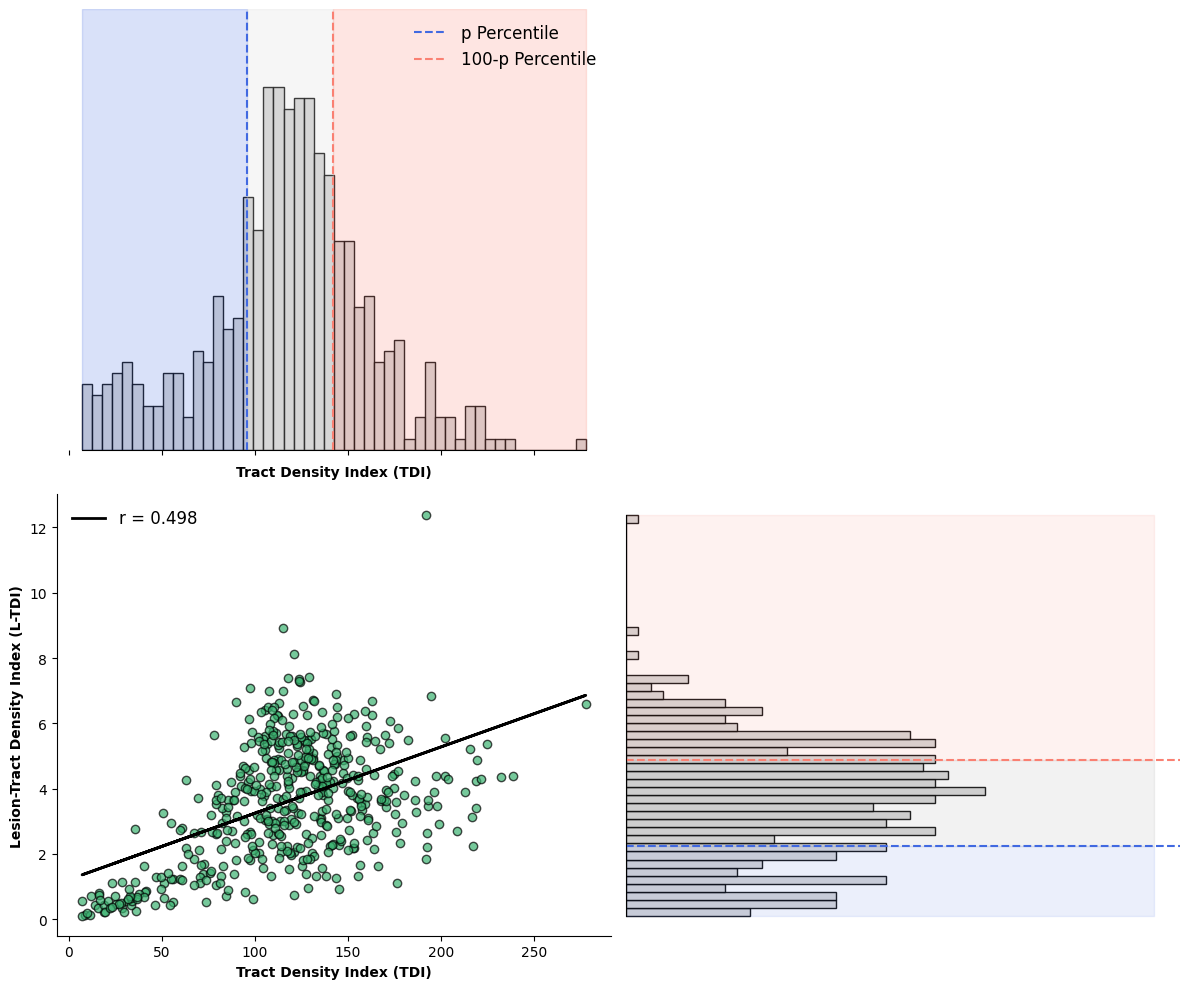

In [47]:
# Prepare the figure
fig, ax = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={"height_ratios": [1, 1]})

# Prepare data for percentile lines
tdi_25, tdi_75 = TDstats["Whole TDMap"].quantile(0.25), TDstats["Whole TDMap"].quantile(0.75)
ltdi_25, ltdi_75 = TDstats["Whole lesion TDMap"].quantile(0.25), TDstats["Whole lesion TDMap"].quantile(0.75)

# Histogram for "Whole TDMap"
tdi = TDstats["Whole TDMap"].dropna()
ax[0, 0].hist(tdi, bins=50, color='lightgray', edgecolor='black', alpha=0.9, density=True)
ax[0, 0].axvline(tdi_25, color='royalblue', linestyle="--", linewidth=1.5, label="p Percentile")
ax[0, 0].axvline(tdi_75, color='salmon', linestyle="--", linewidth=1.5, label="100-p Percentile")
ax[0, 0].fill_betweenx([0, 1], tdi.min(), tdi_25, color="royalblue", alpha=0.2, transform=ax[0, 0].get_xaxis_transform())
ax[0, 0].fill_betweenx([0, 1], tdi_25, tdi_75, color="lightgray", alpha=0.2, transform=ax[0, 0].get_xaxis_transform())
ax[0, 0].fill_betweenx([0, 1], tdi_75, tdi.max(), color="salmon", alpha=0.2, transform=ax[0, 0].get_xaxis_transform())
ax[0, 0].set_xlabel("Tract Density Index (TDI)", fontweight="bold")
ax[0, 0].spines[["top", "right", "left"]].set_visible(False)
ax[0, 0].set_yticks([])
ax[0, 0].set_xticklabels([])
ax[0, 0].legend(loc="upper right", fontsize=12, frameon=False)
ax[0, 0].spines['bottom'].set_bounds(tdi.min(),tdi.max())

# Hide empty subplot (bottom right)
ax[0, 1].axis("off")

# Scatter plot for the relationship between the two variables
ax[1, 0].scatter(
    TDstats["Whole TDMap"], 
    TDstats["Whole lesion TDMap"], 
    alpha=0.7, color="mediumseagreen", edgecolor="black"
)
ax[1, 0].set_xlabel("Tract Density Index (TDI)", fontweight="bold")
ax[1, 0].set_ylabel("Lesion-Tract Density Index (L-TDI)", fontweight="bold")
ax[1, 0].spines[["top", "right"]].set_visible(False)
#ax[1, 0].set_xticklabels([])
#ax[1, 0].set_yticklabels([])

x = TDstats["Whole TDMap"].dropna()
y = TDstats["Whole lesion TDMap"].dropna()
slope, intercept, r_value, _, _ = linregress(x, y)
ax[1, 0].plot(x, slope * x + intercept, color="black", linestyle="-", label=f"r = {r_value:.3f}", linewidth=2)
ax[1, 0].legend(loc="upper left", fontsize=12, frameon=False)

# Histogram for "Whole lesion TDMap"
ltdi = TDstats["Whole lesion TDMap"].dropna()
ax[1, 1].hist(ltdi, bins=50, color='lightgray', edgecolor='black', alpha=0.9, density=True, orientation='horizontal')
ax[1, 1].axhline(ltdi_25, color='royalblue', linestyle="--", linewidth=1.5, label="25th Percentile")
ax[1, 1].axhline(ltdi_75, color='salmon', linestyle="--", linewidth=1.5, label="75th Percentile")
ax[1, 1].fill_between([0, 0.35], ltdi.min(), ltdi_25, color="royalblue", alpha=0.1)
ax[1, 1].fill_between([0, 0.35], ltdi_25, ltdi_75, color="gray", alpha=0.1)
ax[1, 1].fill_between([0, 0.35], ltdi_75, ltdi.max(), color="salmon", alpha=0.1)
ax[1, 1].spines[["top", "right", "bottom"]].set_visible(False)
ax[1, 1].set_yticks([])
ax[1, 1].set_xticks([])
ax[1, 1].spines['left'].set_bounds(ltdi.min(),ltdi.max())

# Adjust layout
fig.tight_layout()
fig.savefig(os.path.join(root, f"Figures/TDMaps_IDH1-WT/{figs_folder}/TDIndices.svg"), dpi=300, format='svg', transparent=True, bbox_inches='tight')